In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working/submission.csv
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/plots/feature_plots.png
/kaggle/working/plots/confusion_matrix_best_svm.png
/kaggle/working/plots/confusion_matrix_best_dt.png
/kaggle/working/plots/pca_analysis.png
/kaggle/working/plots/value_counts.png
/kaggle/working/plots/signal_plots.png
/kaggle/working/plots/confusion_matrix_best_rf.png
/kaggle/working/plots/pca_analysis.png.zip
/kaggle/working/plots/confusion_matrix_best_nb.png
/kaggle/working/cm_plots/confusion_matrix_best_nb.png


In [2]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
# from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler

In [3]:
# Set a random state
random_state = 389

# Set print display variables
thick_line = "========================================"
thin_line = "----------------------------------------"

Feature Based Approach
======================

In [4]:
# Read in data
train_df = pd.read_csv("/kaggle/input/csm6420-a2/train_signal.csv")
train_feat_df = pd.read_csv("/kaggle/input/csm6420-a2/train_feat.csv")

submission_test_df = pd.read_csv("/kaggle/input/csm6420-a2/test_signal.csv")
submission_test_feat_df = pd.read_csv("/kaggle/input/csm6420-a2/test_feat.csv")

In [5]:
# Preprocess data
def preprocess_xysplit_feature_data(df, is_test=False):
    df = df.fillna(0)
    ids = df['ID']
    X_feat_df = df.drop(columns=['Type', 'ID'], errors='ignore')
    
    X_feat_df = pd.DataFrame(X_feat_df)
    
    scaler = StandardScaler()
    X_feat_df = scaler.fit_transform(X_feat_df)
    X_feat_df = pd.DataFrame(X_feat_df)

    if (not is_test):
        Y_feat_df = df["Type"]
    
        return (X_feat_df, Y_feat_df, ids)
    else:
        return (X_feat_df, ids)
        

X_train_feat_df, Y_train_feat_df, train_feat_ids_df = preprocess_xysplit_feature_data(train_feat_df)
X_sub_test_feat_df, sub_test_feat_ids_df = preprocess_xysplit_feature_data(submission_test_feat_df, is_test=True)

print(X_sub_test_feat_df.head())
print(sub_test_feat_ids_df.head())

# Split the data
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(X_train_feat_df, Y_train_feat_df, test_size=0.20, random_state=random_state, stratify=Y_train_feat_df)

        0         1         2         3         4         5         6    \
0  0.267428 -0.348947  0.055474 -0.135976 -0.327608  0.146828 -0.254028   
1  0.420157 -0.591735  0.055474 -0.135976 -0.327608  0.655986  0.007579   
2 -0.114394  0.136629 -0.369611 -1.288316  0.210336  0.146828  0.250542   
3  0.114699 -0.348947 -0.227916 -0.135976 -0.327608  0.146828 -0.178405   
4  0.191064 -0.713129 -0.511306 -0.135976 -0.327608 -0.362330 -0.224194   

        7         8         9    ...       178       179       180       181  \
0 -0.118090 -0.128585 -0.016013  ... -0.660606  1.176850  1.633431 -0.479601   
1  0.212803  0.174580  0.170842  ... -0.724874  1.126346  1.626613 -0.479601   
2 -0.122693 -0.400022  0.044490  ...  0.310169 -0.297389  0.398846 -0.003334   
3 -0.449657 -0.413626 -0.217407  ...  1.559275 -0.030142 -0.776328 -0.479601   
4 -0.419587 -0.349960 -0.238667  ... -0.264898  0.208894  0.877296 -0.479601   

        182       183       184       185       186       187  
0 -0

In [6]:
# Data Exploration

graph_dpi = 600

a_data, n_data, noise_data, o_data = [116, 45, 204, 40]

def plotter(rows, label=False, feature=False):
    df = train_df
    filename = 'signal_plots'
    if feature:
        df = train_feat_df
        filename = 'feature_plots'
    if label != False:
        print(label)
    fig, axs = plt.subplots(2, 2)

    graph_data = {}
    data_range_max = 0
    data_range_min = 0
    for row in rows:
        data = df.iloc[row]
        data_type = data['Type']
        data = data.drop(['Type', 'ID'], errors='ignore')
        if data_range_max < data.shape[0]:
            data_range_max = data.shape[0]
        data = data.tolist()
        graph_data[data_type] = data
        
    data_range =  list(range(0, data_range_max))

    graph_name_preamble = 'Graph of '
    axs[0,0].plot(data_range, graph_data['N'])
    axs[0,0].set_title(graph_name_preamble + 'Normal Rhythm')
    axs[0,1].plot(data_range, graph_data['A'], 'tab:orange')
    axs[0,1].set_title(graph_name_preamble + 'Atrial Fibrillation')
    axs[1,0].plot(data_range, graph_data['O'], 'tab:green')
    axs[1,0].set_title(graph_name_preamble + 'Other Rhythm')
    axs[1,1].plot(data_range, graph_data['~'], 'tab:red')
    axs[1,1].set_title(graph_name_preamble + 'Noise')
    fig.tight_layout()
    
    plt.savefig('plots/' + filename + '.png', dpi=graph_dpi)
            
    plt.show()
    plt.close()
    
def max_min(df):
    tmp_df = df
    tmp_df = tmp_df.drop(['ID', 'Type'], axis=1, errors='ignore')
    max_val = max(tmp_df.max().tolist())
    min_val = min(tmp_df.min().tolist())
    print("Max Val: " + str(max_val))
    print("Min Val: " + str(min_val))

def data_exploration():
    print(thick_line)
    print("General Training Data Exploration")
    print(thick_line)
    print('Types - ' + str(train_feat_df["Type"].nunique()))
    print('Type Counts - ')
    print(str(train_feat_df["Type"].value_counts()))

    counts = pd.DataFrame(train_feat_df["Type"].value_counts())
    counts.plot(kind='bar', legend=False, rot=0)
    plt.savefig('plots/value_counts.png', dpi=graph_dpi)
    plt.show()
    plt.close()

    print(thin_line)
    print("Feature Data Exploration")
    print(thin_line)
    print("Data Shape - " + str(train_feat_df.shape))
    max_min(train_feat_df)
    plotter([a_data, n_data, noise_data, o_data], feature=True)

    print(thin_line)
    print("Signal Data Exploration")
    print(thin_line)
    print(train_df.shape)
    max_min(train_df)
    plotter([a_data, n_data, noise_data, o_data])

    print(thick_line)
    print("General Test Data Exploration")
    print(thick_line)
    print(thin_line)
    print("Feature Data Exploration")
    print(thin_line)
    print(submission_test_feat_df.shape)
    max_min(submission_test_feat_df)

    print(thin_line)
    print("Signal Data Exploration")
    print(thin_line)
    print(submission_test_df.shape)
    max_min(submission_test_df)

# data_exploration()

In [7]:
# Utility function to report best scores in grid search
# From Chuan Lu on Practical 2
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Utility function to make confusion matricies
def classifier_confusion_matrix(Y_test_vals, Y_test_pred_vals, save_confusion_matrix=False):
    disp = ConfusionMatrixDisplay.from_predictions(Y_test_vals, Y_test_pred_vals, cmap=plt.cm.Blues)
    
    if (save_confusion_matrix != False):
        disp.plot(cmap=plt.cm.Blues)
        plt.savefig('plots/confusion_matrix_' + save_confusion_matrix + ".png")

    print(classification_report(Y_test_vals, Y_test_pred_vals))

In [8]:
def split_fit_predict(clf, save_confusion_matrix=False):
    clf.fit(X_train_f, Y_train_f)
    Y_test_f_pred = clf.predict(X_test_f)
    
    classifier_confusion_matrix(Y_test_f, Y_test_f_pred, save_confusion_matrix=save_confusion_matrix)
    return clf
    
def cross_validate(clf): 
    scores = cross_validate(clf, X_train_feat_df, Y_train_feat_df, scoring="roc_auc")
    
def grid_search(clf, param_grid, cv=3, ae=False, evaluate_best=False):
    grid_search = HalvingGridSearchCV(clf, param_grid=param_grid, cv=cv, verbose=1, aggressive_elimination=ae, scoring='f1_weighted', n_jobs=-1)
#     grid_search = HalvingRandomSearchCV(clf, param_grid, cv=cv, verbose=2, aggressive_elimination=ae, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train_feat_df, Y_train_feat_df)
    print(thick_line)
    report(grid_search.cv_results_)
    print(thick_line)
    return grid_search

In [9]:
# Random Forests Classifier
from sklearn.ensemble import RandomForestClassifier

def rfc_classifier():
    rfc = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rfc = split_fit_predict(rfc)
    return rfc
    
def rfc_grid_search(eval_best_params=True):
    rfc = RandomForestClassifier(random_state=random_state)
    
    param_grid = {
#         'n_estimators': [1, 10, 20, 50], 
        "max_depth" : [2, 30, 75], 
        "min_samples_split": [2, 10, 25, 50],
#         'criterion':['gini', 'entropy'],
        "min_samples_leaf": [2, 30, 50, 100],
#         "max_leaf_nodes": [5, 250, 500, 1000],
    }
    
    big_param_grid = {
        'n_estimators': [100, 300, 500], 
        "max_depth" : [2, 10, 50, 75, 100], 
        "min_samples_split": [2, 50, 100, 250],
#         'criterion':['gini', 'entropy'],
        "min_samples_leaf": [2, 30, 50, 100],
        "max_leaf_nodes": [5, 10, 100],
    }
    
    grid_search_results = grid_search(rfc, big_param_grid, ae=True)
    
    if eval_best_params:
        eval_rfc = RandomForestClassifier(random_state=random_state, **grid_search_results.best_params_)
        split_fit_predict(eval_rfc, save_confusion_matrix="best_rf")
    
    return grid_search_results.best_estimator_

# Best Parameters: {'max_depth': 50, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

In [10]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

def nb_classifier():
    nb = GaussianNB()
    nb = split_fit_predict(nb)
    return nb
    
def nb_grid_search(eval_best_params=True):
    nb = GaussianNB()
    
    param_grid = {
        'var_smoothing': np.logspace(-5,5,30),
        
    }
    
    grid_search_results = grid_search(nb, param_grid, ae=True)
    
    if eval_best_params:
        eval_nb = GaussianNB(**grid_search_results.best_params_)
        split_fit_predict(eval_nb, save_confusion_matrix="best_nb")
    
    return grid_search_results.best_estimator_

# Best Parameters: {'var_smoothing': 0.0005298316906283713}

In [11]:
# SVM Classifier
from sklearn.svm import SVC

def svm_classifier(best=False):
    svc = SVC(kernel='linear')
    svc = split_fit_predict(svc)
    return svc

def svm_grid_search(eval_best_params=True):
    svc = SVC(random_state=random_state)
    
    C_param_grid = np.logspace(-5,4,15)#[0.1, 1, 10, 100]
    param_grid = [
        {
            'kernel': ['rbf', 'poly'],
            'gamma': np.logspace(-5, 4, 15),
            'C': C_param_grid,
            'decision_function_shape': ['ovo', 'ovr'],
        },
        {
            'kernel': ['linear'],
            'C': C_param_grid,
            'decision_function_shape': ['ovo', 'ovr'],
        }
    ]
    
    grid_search_results = grid_search(svc, param_grid, ae=True)
    
    if eval_best_params:
        eval_svm = SVC(random_state=random_state, **grid_search_results.best_params_)
        split_fit_predict(eval_svm, save_confusion_matrix="best_svm")
    
    return grid_search_results.best_estimator_
# Best Parameters: {'C': 6.105402296585339, 'decision_function_shape': 'ovr', 'gamma': 0.0008483428982440725, 'kernel': 'rbf'}

In [12]:
from sklearn.tree import DecisionTreeClassifier

def dt_classifier():
    dt = DecisionTreeClassifier(random_state=random_state)
    dt = split_fit_predict(dt)
    return dt

def dt_grid_search(eval_best_params=True):
    dt = DecisionTreeClassifier(random_state=random_state)
    
    param_grid = {
        "max_depth" : [2, 10, 50, 75, 100], 
        "min_samples_split": [2, 50, 100, 250],
        'criterion':['gini', 'entropy'],
        "min_samples_leaf": [2, 30, 50, 100],
        "max_leaf_nodes": [5, 10, 100],
        "splitter": ["best", "random"],
    }
    
    grid_search_results = grid_search(dt, param_grid, ae=True)
    
    if eval_best_params:
        eval_dt = DecisionTreeClassifier(random_state=random_state, **grid_search_results.best_params_)
        split_fit_predict(eval_dt, save_confusion_matrix="best_dt")
    
    return grid_search_results.best_estimator_
# Best Parameters: {'criterion': 'gini', 'max_depth': 100, 'max_leaf_nodes': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}

In [13]:
def PCA_X_data(training_df, testing_df, components=29):
    pca = PCA(n_components=components, random_state=random_state)
    
    pca_train_df = pca.fit_transform(training_df)
    pca_train_df = pd.DataFrame(pca_train_df)
    pca_test_df = pca.transform(testing_df)
    pca_test_df = pd.DataFrame(pca_test_df)
    
    return (pca_train_df, pca_test_df)

In [14]:
# PCA Experimentation

def PCA_experimentation(chosen_clf = False):
    metrics = {}
#     pca_feat_df = train_feat_df.drop(['ID'], axis=1)

    for x in range(1, X_train_f.shape[1]+1):
        print(f"Components - {x}")

        clf = RandomForestClassifier(n_estimators=10, random_state=random_state)
        if (chosen_clf != False):
            clf = chosen_clf
        
        pca_X_train_f, pca_X_test_f = PCA_X_data(X_train_f, X_test_f, x)

        clf.fit(pca_X_train_f, Y_train_f)

        pca_Y_test_f_pred = clf.predict(pca_X_test_f)

        metrics[x] = classification_report(Y_test_f, pca_Y_test_f_pred, output_dict= True)

    return metrics

In [15]:
def PCA_analysis(metrics):
    outer_metric = 'weighted avg'
    clean_metrics = {}
    best_num_components = {}
    chosen_metrics = ['f1-score', 'precision', 'recall', 'accuracy']
    
    for metric in chosen_metrics:
        clean_metrics[metric] = []
        best_num_components[metric] = []
        
    for key, metric in metrics.items():
        for chosen_metric in chosen_metrics:
            metric_value = -1
            if chosen_metric == 'accuracy':
                metric_value = metric[chosen_metric]
            else:
                metric_value = metric[outer_metric][chosen_metric]
                
            clean_metrics[chosen_metric].append(metric_value)
        
    clean_metrics = pd.DataFrame.from_dict(clean_metrics)
    data_range = list(range(0, len(clean_metrics[chosen_metrics[0]])))
    
    print(thick_line)
    print("PCA Analysis")
    print(thick_line)
    for metric in chosen_metrics:
        print(f'Best Value for {metric} is {max(clean_metrics[chosen_metric])} with {clean_metrics[chosen_metric].argmax()} components')
    print(thin_line)
    
    
    fig, axs = plt.subplots(len(chosen_metrics), figsize=(7, 2*len(chosen_metrics)))
    for x in range(0, len(chosen_metrics)):
        axs[x].plot(data_range, clean_metrics[chosen_metrics[x]])
        axs[x].set_title(chosen_metrics[x])
    
    fig.tight_layout()
    plt.savefig('plots/pca_analysis.png', dpi=graph_dpi)
    plt.show()
    plt.close()

Components - 1
Components - 2
Components - 3
Components - 4
Components - 5
Components - 6
Components - 7
Components - 8
Components - 9
Components - 10
Components - 11
Components - 12
Components - 13
Components - 14
Components - 15
Components - 16
Components - 17
Components - 18
Components - 19
Components - 20
Components - 21
Components - 22
Components - 23
Components - 24
Components - 25
Components - 26
Components - 27
Components - 28
Components - 29
Components - 30
Components - 31
Components - 32
Components - 33
Components - 34
Components - 35
Components - 36
Components - 37
Components - 38
Components - 39
Components - 40
Components - 41
Components - 42
Components - 43
Components - 44
Components - 45
Components - 46
Components - 47
Components - 48
Components - 49
Components - 50
Components - 51
Components - 52
Components - 53
Components - 54
Components - 55
Components - 56
Components - 57
Components - 58
Components - 59
Components - 60
Components - 61
Components - 62
Components - 63
C

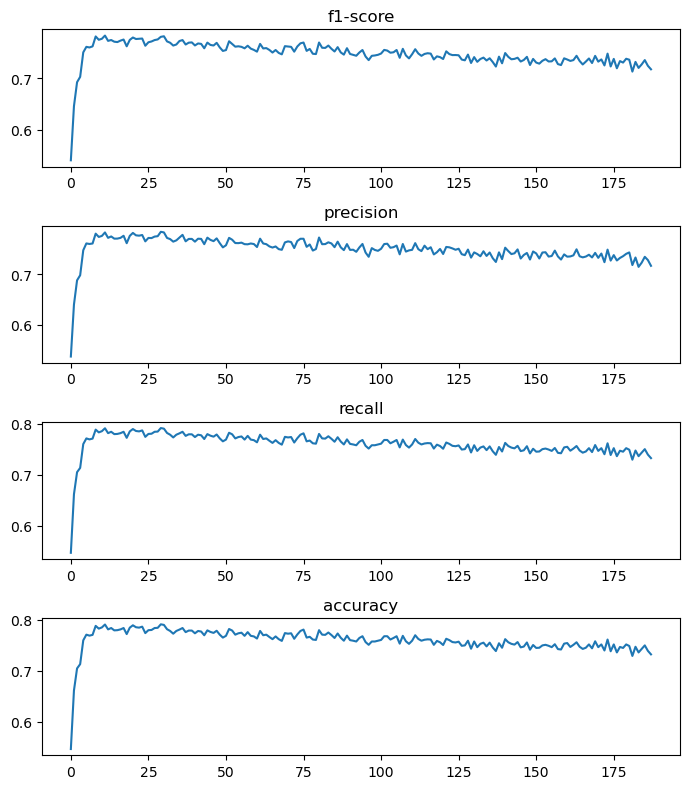

In [16]:
metrics = PCA_experimentation()
PCA_analysis(metrics)

In [17]:
# rfc = rfc_classifier()
# nb = nb_classifier()
# svm = svm_classifier()
# dt = dt_classifier()

# svm = svm_grid_search()
# rfc = rfc_grid_search()
# nb = nb_grid_search()
# dt = dt_grid_search()

In [18]:
def feature_submission():
    global X_train_feat_df, X_sub_test_feat_df
    pca_X_train, pca_X_test = PCA_X_data(X_train_feat_df, X_sub_test_feat_df, 75)
    X_train_feat_df = pca_X_train
    X_sub_test_feat_df = pca_X_test
    
    clf = svm_grid_search(eval_best_params=False)

    feat_preds = clf.predict(X_sub_test_feat_df)

    submission_df = pd.concat([sub_test_feat_ids_df, pd.DataFrame(feat_preds, columns=["Predicted"])], axis=1)
    submission_df['Predicted'] = submission_df['Predicted'].fillna('N')

    print(submission_df['Predicted'].value_counts()['A'])
    
    submission_df.to_csv('/kaggle/working/submission.csv', columns=["ID","Predicted"], index=False)
feature_submission()

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 24
max_resources_: 13062
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 930
n_resources: 24
Fitting 3 folds for each of 930 candidates, totalling 2790 fits
----------
iter: 1
n_candidates: 310
n_resources: 24
Fitting 3 folds for each of 310 candidates, totalling 930 fits
----------
iter: 2
n_candidates: 104
n_resources: 72
Fitting 3 folds for each of 104 candidates, totalling 312 fits
----------
iter: 3
n_candidates: 35
n_resources: 216
Fitting 3 folds for each of 35 candidates, totalling 105 fits
----------
iter: 4
n_candidates: 12
n_resources: 648
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 5
n_candidates: 4
n_resources: 1944
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 6
n_candidates: 2
n_resources: 5832
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Model with rank: 1
Mean validation score: 0.807 (st

End-To-End
----------


In [19]:
train_df = train_df.fillna(0)
plot_train_df = train_df.drop(['ID', 'Type'], axis=1)
print(plot_train_df.head())
print(plot_train_df.iloc[0])
min_val = min(plot_train_df.min().tolist())
max_val = max(plot_train_df.max().tolist())


image_size = (350, 200) #(585,413)
cnn_image_shape = (image_size[0], image_size[1], 1)

      X0     X1     X2     X3     X4     X5     X6     X7     X8     X9  ...  \
0 -0.107 -0.100 -0.086 -0.078 -0.071 -0.057 -0.049 -0.035 -0.028 -0.013  ...   
1  2.762  3.313  3.863  4.292  4.594  4.623  4.408  3.817  3.400  3.203  ...   
2 -0.246 -0.200 -0.159 -0.125 -0.101 -0.090 -0.084 -0.078 -0.072 -0.067  ...   
3  0.519  0.778  1.073  1.392  1.672  1.895  2.012  2.023  1.946  1.747  ...   
4  0.011 -0.103 -0.265 -0.371 -0.409 -0.422 -0.418 -0.411 -0.386 -0.224  ...   

   X5990  X5991  X5992  X5993  X5994  X5995  X5996  X5997  X5998  X5999  
0 -1.108 -1.072 -1.028 -0.978 -0.912 -0.862 -0.804 -0.724 -0.630 -0.499  
1 -0.107  0.003  0.148  0.241  0.310  0.345  0.368  0.397  0.426  0.438  
2 -0.113 -0.038  0.032  0.107  0.165  0.194  0.194  0.159  0.119  0.072  
3  0.037 -0.052 -0.084 -0.099 -0.101 -0.090 -0.067  0.003  0.096  0.179  
4  0.776  0.829  0.763  0.481  0.126 -0.144 -0.224 -0.250 -0.222 -0.207  

[5 rows x 6000 columns]
X0      -0.107
X1      -0.100
X2      -0.086
X3   

In [20]:
import gc
from keras.utils import image_dataset_from_directory

def folder_exists(folder_name, empty_folder=False):
    if os.path.exists(folder_name):
        if (empty_folder):
            for dirname, _, filenames in os.walk(folder_name):
                for filename in filenames:
                    os.remove(folder_name + '/' + filename)
    else:
        os.mkdir(folder_name)
    return folder_name

def image_gen(image_gen_df, folder_name="") :
    folder_name = folder_name
    ids = image_gen_df['ID']
    image_gen_df = image_gen_df.drop(['Type', 'ID'], axis=1, errors="ignore")
    folder_exists(folder_name, empty_folder=False)
    len_dataset = image_gen_df[image_gen_df.columns[0]].count()
    for i in range(len_dataset):
    #     print(train_df['Type'].iloc[i])
        image_gen_df.iloc[i].plot(kind='line', ylim=(min_val, max_val))
        plt.axis('off')
    #     plt.show()
        sub_folder_name = folder_exists(folder_name) + train_df['Type'].iloc[i]
        folder_exists(sub_folder_name)
        plt.savefig(sub_folder_name + "/" + str(i) + '_graph.png')
        plt.clf()
        plt.close()
        gc.collect()
        print(ids.iloc[i], end='', flush=True)
    del image_gen_df; gc.collect()
        
def generate_train_test_dataset(load_train=True, train=True, test=True, small_train=False):
    train_dir_name = '/kaggle/working/signal_graphs/'
    if (load_train):
        train_dir_name = '/kaggle/input/train-signal-graphs-equalised-centre-lines/signal_graphs/'
    test_dir_name = '/kaggle/working/submission_test_signal_graphs/'
    
    ret_ds = {"train": [], "train_validation": [], "test":[]}
    
    label_mode = 'categorical'
    color_mode = 'grayscale'
    batch_size = 8
        
    if (train):
        if (not load_train):
            train_df_temp = train_df
            if (small_train != False):
                train_df_temp = train_df.iloc[0:small_train]
            image_gen(train_df_temp, folder_name=train_dir_name)
            
        validation_split=0.3
        ret_ds['train'] = image_dataset_from_directory(train_dir_name,
                                                       label_mode = label_mode,
                                                       color_mode=color_mode,
                                                       image_size=image_size,
                                                       batch_size=batch_size,
                                                       validation_split = validation_split,
                                                       subset = "training",
                                                       seed = random_state)
        ret_ds['train_validation'] = image_dataset_from_directory(train_dir_name,
                                                                  label_mode = label_mode,
                                                                  color_mode=color_mode,
                                                                  image_size=image_size,
                                                                  batch_size=batch_size,
                                                                  validation_split = validation_split,
                                                                  subset = "validation",
                                                                  seed = random_state)
        print("training images generated")
    if (test):
        image_gen(submission_test_df, folder_name=test_dir_name)
        ret_ds['test'] = image_dataset_from_directory(train_dir_name,
                                                      color_mode=color_mode,
                                                      batch_size=batch_size,
                                                      image_size=image_size)
        print("testing images generated")
    
    return ret_ds

In [21]:
import os

def filechecks():
    count = 0
    for dirname, _, filenames in os.walk('/kaggle/working'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            if ('signal_graphs' in dirname):
                count += 1
    #         os.remove(dirname + '/' + filename)
    print(count)

def training_validation_graphs(train_vals, val_vals, stat='loss'):
    epochs = range(1, len(train_vals) + 1)
    plt.plot(epochs, train_vals, "--", color='green', label="Training " + stat)
    plt.plot(epochs, val_vals, "-", label="Validation " + stat) 
    plt.title("Training and validation " + stat)
    plt.xlabel("Epochs")
    plt.ylabel(stat.capitalize())
    plt.legend()
    plt.show()
    plt.close()

def fitting_scores(history):
    history_dict = history.history
    
    metrics = ['loss', 'accuracy', 'categorical_accuracy']
    
    for metric in metrics:
        values = history_dict[metric] # on training set
        val_values = history_dict["val_" + metric] # on validation set
        training_validation_graphs(values, val_values, metric)
    
# filechecks()

In [22]:
# CNN architecture
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7180882/

import tensorflow as tf
from tensorflow import keras
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.utils import image_dataset_from_directory

# Good Practice Klaxon: Free your memory from previously made models.
clear_session()

In [23]:
# Use function to define different models for reuse in experimments
def create_cnn_v1():
    model = Sequential()    
    model.add(Input(shape=cnn_image_shape))
    
#     model.add(Conv2D(256, kernel_size=(9, 9), activation='softmax'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
#     model.add(Conv2D(256, kernel_size=(9, 9), activation='softmax'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
    
#     model.add(Dropout(0.5))
    
    model.add(Conv2D(128, kernel_size=(7, 7), activation='softmax'))
    model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(7, 7), activation='softmax'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(64, kernel_size=(5, 5), activation='softmax'))
    model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='softmax'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='softmax'))
    model.add(BatchNormalization())
#     model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='softmax'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model

In [24]:
def create_cnn_v2():
    model = Sequential()    
    model.add(Input(shape=cnn_image_shape))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='softmax'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='softmax'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25)) # Dropout 25% of the nodes of the previous layer during training
    model.add(Flatten())     # Flatten, and add a fully connected layer
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax')) # Last layer: 4 class nodes, with dropout    
    return model

In [25]:
def create_cnn_v3():
    model = Sequential()
    model.add(Input(shape=cnn_image_shape))
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Conv2D(256, kernel_size=(7, 7), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))
    return model

In [26]:
def create_cnn_v4():
    model = Sequential()
    model.add(Input(shape=cnn_image_shape))
    
    
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Dense(64))
    
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))
    return model

In [27]:
def create_cnn_v5():
    model = Sequential()
    model.add(Input(shape=cnn_image_shape))
    
    model.add(Conv2D(8, kernel_size=(4,4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(13, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(71, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(129, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model

In [28]:
def create_cnn_v6():
    model = Sequential()
    model.add(Input(shape=cnn_image_shape))
    
    model.add(Conv2D(8, kernel_size=(8,8), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(13, kernel_size=(6,6), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(71, kernel_size=(4,4), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(129, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(176, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(261, kernel_size=(2,2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model

Found 13062 files belonging to 4 classes.
Using 9144 files for training.
Found 13062 files belonging to 4 classes.
Using 3918 files for validation.
training images generated
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 347, 197, 8)       136       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 173, 98, 8)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 172, 97, 13)       429       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 86, 48, 13)       0         
 2D)                                                             
                                                                 
 conv2d_6 (C

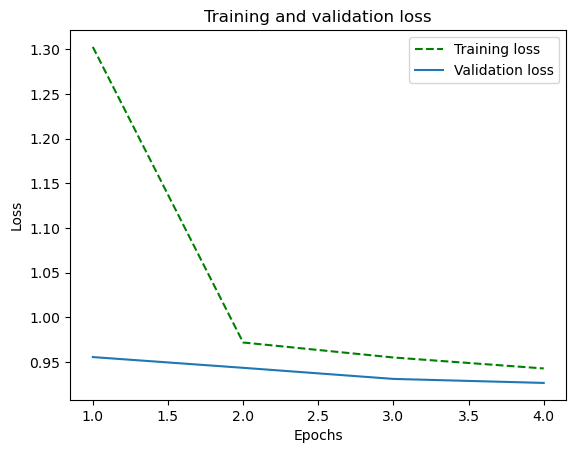

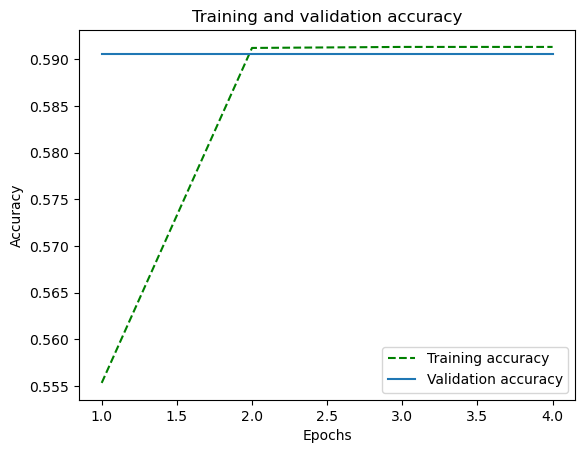

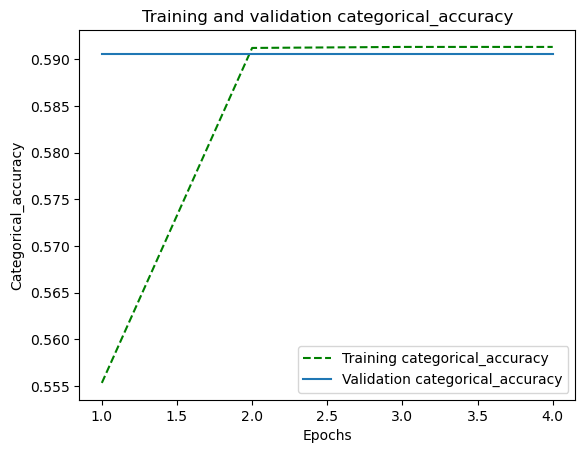

In [30]:
def create_compile_fit_score():
    model=create_cnn_v5()
    model.summary()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=3)
    model.compile(optimizer="adam",
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy'])
    history = model.fit(
        ds['train'],
        epochs=500, 
        validation_data=ds['train_validation'],
        callbacks=[callback]
    )
    fitting_scores(history)

ds = generate_train_test_dataset(load_train=True, test=False)
create_compile_fit_score()